In [1]:
import warnings

In [1]:
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def getPCA(matrix) :
    # Get eVal, eVec from a Hermitian matrix
    ## np.linalg.eigh : 복잡한 Hermitian 또는 실제 대칭 행렬의 고유 값과 고유 벡터를 반환
    eVal, eVec = np.linalg.eigh(matrix) ## eigenvalue, eigenvector
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc   
    eVal = eVal[indices]
    eVec = eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec


def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N
    eMin = var * (1 - (1.0 / q) ** 0.5) ** 2
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    if len(pdf.shape) > 1 :
        pdf = pdf.squeeze()
    pdf = pd.Series(pdf, index = eVal)
    return pdf


def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x=None) :
    # Fit kernel to a series of obs, and derive the probability of obs
    # x : the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1 :
        obs = obs.reshape(-1,1)
    if x is None :
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1 :
        x = x.reshape(-1, 1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    logProb = kde.score_samples(x) #log(density)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    return pdf

def draw_mpPDF(a, b):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(pdf0, label = "Marcenko-Pastur")
    ax.plot(pdf1, '--',label = "Empirical:KDE")
    ax.set_title('Figure 2.1 A visualiztion of the Marcenko-Pastur theorem\n', fontsize = 18)
    ax.set_ylabel('prob[$\lambda$]', fontsize = 15)
    ax.set_xlabel('$\lambda$', fontsize = 15)
    leg = ax.legend(fontsize= 15)
    fig.show()
    

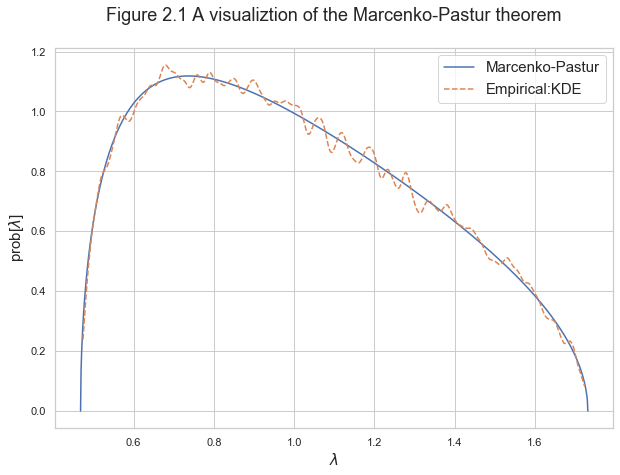

In [3]:
### T : time, N : # of assets
T, N = 10000, 1000
## 이론적 random matrix 구현
## 행렬 X는 T X N 크기의 랜덤행렬
X = np.random.normal(size = (T,N))
## C는 1/T x X'X
C = np.corrcoef(X, rowvar=0)
## PCA 진행하여 eigenvalue, eigenvector 추출
eVal0, eVec0 = getPCA(C)
## eVal0 : eigen Values, eVec0 : eigen vectors
### Random Matrix라면 eigen Values가 MPpdf 범위 내에 존재해야 함
q = T/float(N)
# Marcenko-Pastur pdf 구하기
pdf0 = mpPDF(1.0, q = q, pts = 1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)
draw_mpPDF(pdf0, pdf1)

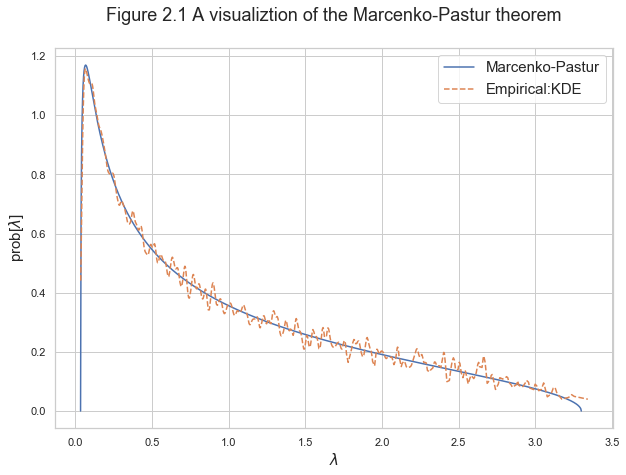

In [5]:
### T : time, N : # of assets
T, N = 1500, 1000
## 이론적 random matrix 구현
## 행렬 X는 T X N 크기의 랜덤행렬
X = np.random.normal(size = (T,N))
## C는 1/T x X'X
C = np.corrcoef(X, rowvar=0)
## PCA 진행하여 eigenvalue, eigenvector 추출
eVal0, eVec0 = getPCA(C)
## eVal0 : eigen Values, eVec0 : eigen vectors
### Random Matrix라면 eigen Values가 MPpdf 범위 내에 존재해야 함
q = T/float(N)
# Marcenko-Pastur pdf 구하기
pdf0 = mpPDF(1.0, q = q, pts = 1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)
draw_mpPDF(pdf0, pdf1)

## 2.3

In [2]:
def getRndCov(nCOls, nFacts) :
    w = np.random.normal(size = (nCols, nFacts))
    # Random cov matrix, however not full rank
    cov = np.dot(w, w.T)
    # Make full rank cov
    cov += np.diag(np.random.uniform(size=nCols)) 
    return cov

def cov2corr(cov) :
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std,std)
    # Clipping to prevent numerical errors
    corr[corr <-1] = -1
    corr[corr > 1] = 1
    return corr

return of 500 stocks, Marcenko-Pastur's theorem를 통해 maximum eignevalue를 찾아야 함


In [12]:
from scipy.optimize import minimize
def errPDFs(var, eVal, q, bWidth, pts = 1000) :
    # Fit error
    # Theoretical pdf   
    # prevent var values in list format
    if hasattr(var, "__len__") :
        if len(var) == 1 :
            var = var[0]
        else :
            raise ValueErroral ("var  must be scalar")
    pdf0 = mpPDF(var, q, pts)
    # Empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    return sse

def findMaxEval(eVal, q, bWidth) :
    # Find Max random eVal by fitting Marcenko's distribution
    # Scipy.optimize.minimize
    # fun : Theobjective function to be minimized
    # x0 : ndarray, shape(n,), initial guess. array of real emlements of size
    
    out = minimize(fun = lambda *x : errPDFs(*x), x0 = .5, # first arg : var
                   args = (eVal, q, bWidth), bounds = ((1e-5, 1 - 1e-5),))
    if out['success'] :
        var = out['x'][0]
    else :
        var = 1
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    return eMax, var

In [28]:
## alpha : random covariance의 비중
alpha = 0.995
## nCols : 전체 asset의 수
nCols = 1000
# nFact : signal을 갖고 있는 # of columns 
nFact = 100
q = 10
# cov : covariance matrix 
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar = 0)
# make noise + signal covariance matrix (weights = alpha)
cov = alpha * cov + (1-alpha) * getRndCov(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

In [29]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

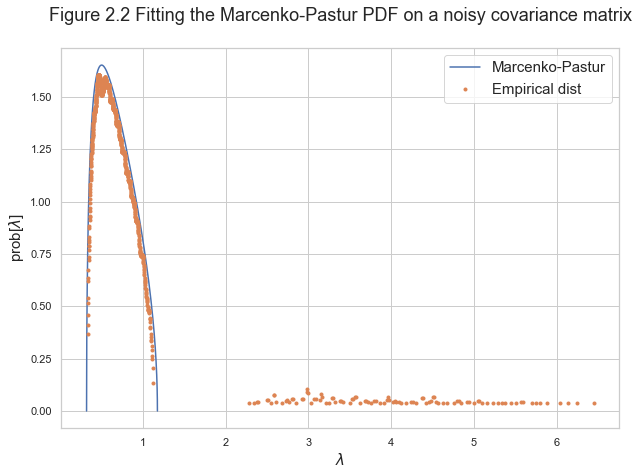

In [30]:
# make graphs
pdf0 = mpPDF(var0, q = q, pts = 1000)
# Empricial PDF
pdf1 = fitKDE(np.diag(eVal0), bWidth = 0.01)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(pdf0, label = "Marcenko-Pastur")
ax.plot(pdf1,label = "Empirical dist", marker=".", linestyle="")
ax.set_title('Figure 2.2 Fitting the Marcenko-Pastur PDF on a noisy covariance matrix\n', fontsize = 18)
ax.set_ylabel('prob[$\lambda$]', fontsize = 15)
ax.set_xlabel('$\lambda$', fontsize = 15)
leg = ax.legend(fontsize= 15)